Notebook to show rough effect of adding various things to the model (using default random forest parameters)

**Imports**

In [1]:

import os

import pandas as pd
import numpy as np

import sklearn as sk
import sklearn.pipeline



import pyplotterlib.standard.plotters as ppl

import project_path
import model_wrappers as modelWrapHelp
import preproc_pipes as preProcPipeHelp
import train_pipes as trainPipeHelp

**Configuration Variables**

In [2]:
#Initially used to generate 5 random seeds
# _rngBackend = np.random.MT19937()
# _rng = np.random.Generator(_rngBackend)
# _rng.integers(0,high=1e5, size=5)

In [3]:
#Also same features used for PCA
FEATS_TO_CLUSTER = ['OverallQual','GrLivArea','TotalBsmtSF','Neighborhood_m10','BsmtFinSF1',
            'GarageFinish','KitchenQual','GarageArea','SaleCondition_m10','LotArea',
            'MoSold','LotShape', 'FireplaceQu','BsmtExposure', 'TotRmsAbvGrd',
            'YearRemodAdd', 'MSSubClass','WoodDeckSF','MasVnrArea']
N_KMEANS_CLUSTERS = 2

#
EXTRA_FEATS = ["BsmtFractUnfurnished", "GarageAreaTimesFinish", "NumbBsmtBath", "NumbBath",
               "OverallQualTimesCond", "PoolQualTimesCond", "PorchLikeArea", "Spaciousness",
               "TotalSFLiv", "TotalSFLivOverLotArea", "YearSold_Fract"]

#
TARG_ENC_FEATS = ["Neighborhood", "Exterior1st", "Condition1", "HouseStyle", "GarageType",
                  "Foundation", "LotConfig", "SaleType", "RoofMatl", "MSZoning", "SaleCondition",
                  "RoofStyle"]
TARG_ENC_MVAL = 10

#
RANDOM_SEEDS = [78509, 64116, 69378, 66115, 83655]


#
TOP_CMI = ['TotalSFLiv', 'YearBuilt', 'OverallQualTimesCond', 'BsmtUnfSF', 'LotArea',
                  'GarageAreaTimesFinish', 'BsmtQual', 'Neighborhood', 'Neighborhood_m10',
                 'TotRmsAbvGrd', 'PorchLikeArea',
                  'SaleCondition', 'BsmtFinSF1', 'GrLivArea', 'KitchenQual', 'BsmtExposure',
                  'BsmtFinType1', 'FireplaceQu', 'LandContour', 'HeatingQC', 'MasVnrArea']


#
TRAIN_PATH = os.path.abspath( os.path.join("..","..","raw_data","train.csv")  )

#
_currKwargs = {"constrainedLayout":True, "figHeightPerRow":2.5, "figWidthPerCol":4, "nColsGrid":4}
RECT_PLOTTER = ppl.RectMultiPlotter(**_currKwargs)


**Import data**

In [4]:
RAW_TRAIN = pd.read_csv(TRAIN_PATH)

**Apply shared pre-processing options**

In [5]:
#Remove anything from the training set i know to be an outlier [from results in other notebooks]
_outlierIDs = [524, 945, 1299]

#Features we add before any factorisation/cleaning
_preFactorFeats = ["FenceQual", "NumbStoreys_fromHouseStyle"]

#
_ordEncoder = preProcPipeHelp.OrdinalEncoder( preProcPipeHelp.getStandardOrdinalEncodeKeys() )

#
_preProcComps = [ ("Add some pre-factorisation features", preProcPipeHelp.EngFeatureAdder(_preFactorFeats) ),
                  ("Remove outliers", preProcPipeHelp.RemoveOutliersById(_outlierIDs) ),
                 ("Replace text values with basic ordinal encoding", _ordEncoder),
                 ("Factorise any remaining categorical groups", preProcPipeHelp.FactorizeRemainingCateGroups() ), ]

preProcPipe = sk.pipeline.Pipeline(_preProcComps)


In [6]:
PROC_TRAIN = preProcPipe.fit_transform(RAW_TRAIN)

In [7]:
START_FEATS = PROC_TRAIN.columns
START_FEATS = START_FEATS.drop("Id")
START_FEATS = START_FEATS.drop("SalePrice")

In [8]:
START_FEATS

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

**Create a training pipe; applied to all at training time**

In [9]:
#
_targEncodeTrain = trainPipeHelp.MEncodeMultiple(TARG_ENC_FEATS, mVal=TARG_ENC_MVAL)
_pcaPipe = trainPipeHelp.AddPCA(FEATS_TO_CLUSTER, nComponents=1)
_clusterPipe = trainPipeHelp.AddKMeansClusters(FEATS_TO_CLUSTER, N_KMEANS_CLUSTERS, randomState=RANDOM_SEEDS[0],
                                               useMinDist=True)

_trainPipeComps = [ ("Impute NaN values for numerical fields", trainPipeHelp.TransformNumericalNaN()),
                    ("Add remaining engineered features", preProcPipeHelp.EngFeatureAdder(EXTRA_FEATS) ),
                    ("Add target encoded features", _targEncodeTrain ),
                    ("Add PCA component(s)", _pcaPipe),
                    ("Add kmeans cluster information", _clusterPipe)
                  ]
TRAIN_PIPE = sk.pipeline.Pipeline(_trainPipeComps)


**Create a dicts to store the varied results in**

In [10]:
USE_DICT_STAGE_A = dict()
USE_DICT_STAGE_B = dict()
USE_DICT_STAGE_C = dict()

**Define a function for getting CV errors**

In [11]:
def scoreForRandomSeedShuffles(inpFrame, inpFeats, randomSeeds, logTarget=False):
    outVals = list()
    useModel = modelWrapHelp.RandomForestWrapper(inpFeats, trainPipe=TRAIN_PIPE, logTarget=logTarget)
    for seed in randomSeeds:
        useX = inpFrame.copy()
        useX = useX.sample(frac=1.0, random_state=seed)
        currScore = np.mean( sk.model_selection.cross_val_score(useModel, useX) )
        outVals.append(currScore)
    return outVals
        

**Figure out error for the base-model**

In [12]:
%%prun
#
_modelName = "baseline_a"
_useFeats = START_FEATS
_logTarget = False

#
USE_DICT_STAGE_A[_modelName] = scoreForRandomSeedShuffles(PROC_TRAIN, _useFeats, randomSeeds=RANDOM_SEEDS, logTarget=_logTarget)

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]


**Fit to log(target)**

In [13]:
%%prun
#
_modelName = "log_target"
_useFeats = START_FEATS
_logTarget = True

#
USE_DICT_STAGE_A[_modelName] = scoreForRandomSeedShuffles(PROC_TRAIN, _useFeats, randomSeeds=RANDOM_SEEDS, logTarget=_logTarget)

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

**Add Target encoded**

In [14]:
%%prun
#         19566137 function calls (19277778 primitive calls) in 56.896 seconds
#
_modelName = "targ_enc"
_useFeats = list(START_FEATS) + [feat + "_m10" for feat in TARG_ENC_FEATS] 
_logTarget = False

#
USE_DICT_STAGE_A[_modelName] = scoreForRandomSeedShuffles(PROC_TRAIN, _useFeats, randomSeeds=RANDOM_SEEDS, logTarget=_logTarget)

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]


**Add extra engineered features**

In [15]:
%%prun
#19565973 function calls (19277639 primitive calls) in 61.891 seconds

#
_modelName = "extra_feats"
_useFeats = list(START_FEATS) + list(EXTRA_FEATS)
_logTarget = False

#
USE_DICT_STAGE_A[_modelName] = scoreForRandomSeedShuffles(PROC_TRAIN, _useFeats, randomSeeds=RANDOM_SEEDS, logTarget=_logTarget)

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]


**Restrict to features with best cmi only**

In [16]:
%%prun
#19553416 function calls (19266882 primitive calls) in 44.516 seconds

_modelName = "best_cmi"
_useFeats = list(TOP_CMI)
_logTarget = False

#
USE_DICT_STAGE_A[_modelName] = scoreForRandomSeedShuffles(PROC_TRAIN, _useFeats, randomSeeds=RANDOM_SEEDS, logTarget=_logTarget)

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]


**Stage B baseline**

In [17]:
%%prun
#19558766 function calls (19272107 primitive calls) in 44.502 seconds

_modelName = "baseline_b"
_useFeats = list(TOP_CMI)
_logTarget = True

#
USE_DICT_STAGE_B[_modelName] = scoreForRandomSeedShuffles(PROC_TRAIN, _useFeats, randomSeeds=RANDOM_SEEDS, logTarget=_logTarget)

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]


**Add PCA to b**

In [18]:
%%prun
#19765059 function calls (19450375 primitive calls) in 47.100 seconds

_modelName = "plus_pca"
_useFeats = list(TOP_CMI) + ["pc_0"]
_logTarget = True

#
USE_DICT_STAGE_B[_modelName] = scoreForRandomSeedShuffles(PROC_TRAIN, _useFeats, randomSeeds=RANDOM_SEEDS, logTarget=_logTarget)


/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]


**Add cluster keys to b**

In [19]:
%%prun
#19768811 function calls (19454052 primitive calls) in 48.507 seconds

_modelName = "plus_clusters"
_useFeats = list(TOP_CMI) + ["clusterIdx", "cDist_0", "cDist_1", "clusterMinDist"]
_logTarget = True

#
USE_DICT_STAGE_B[_modelName] = scoreForRandomSeedShuffles(PROC_TRAIN, _useFeats, randomSeeds=RANDOM_SEEDS, logTarget=_logTarget)


/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]


**Add pca AND cluster keys to b**

In [20]:
%%prun
#19769004 function calls (19454220 primitive calls) in 49.547 seconds


_modelName = "plus_clusters_pca"
_useFeats = list(TOP_CMI) + ["clusterIdx", "cDist_0", "cDist_1", "clusterMinDist"] + ["pc_0"]
_logTarget = True

#
USE_DICT_STAGE_B[_modelName] = scoreForRandomSeedShuffles(PROC_TRAIN, _useFeats, randomSeeds=RANDOM_SEEDS, logTarget=_logTarget)


/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:247: SettingWithCopyWarning: 
A value is trying to be set on

**Create various plots showing the effects of different strategies**

In [21]:
def getStandardPlotterForKeys(inpDict, inpKeys):
    #
    templPlotter = _getTemplPlotter()
    plotData = list()
    for key in inpKeys:
        currData = [ [idx,val] for idx,val in enumerate(sorted(inpDict[key]))]
        plotData.append(currData)
    outPlotter = templPlotter.createFactory(dataLabels=list(inpKeys),plotData=plotData,
                                            legendNumbCols=1, legendFractPosStart=[1,0.2])
    return outPlotter

def _getTemplPlotter():
    _currKwargs = {"fontSizeDefault":12, "gridLinesShowY":True, "lineMarkerStyles":["x"],
               "showLegend":True,
               "xLabelStr":"Attempt (Sorted by loss)", "yLabelStr":"Cross-Validation Loss"}
    templPlotter = ppl.LinePlotter(**_currKwargs)
    return templPlotter


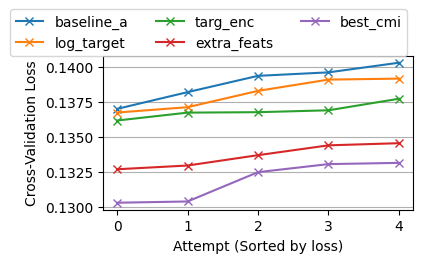

In [22]:
stageAPlotter = getStandardPlotterForKeys(USE_DICT_STAGE_A, USE_DICT_STAGE_A.keys())
unused = stageAPlotter.createPlot(legendNumbCols=3, legendFractPosStart=[-0.3,1], figSizeOnCreation=(4,2),
                                  fontSizeDefault=10)

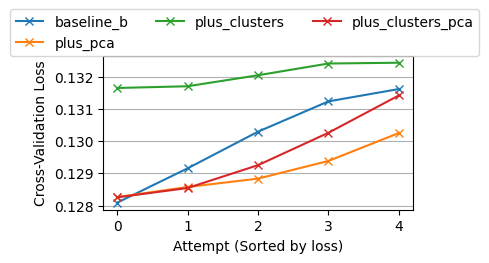

In [23]:
stageBPlotter = getStandardPlotterForKeys(USE_DICT_STAGE_B, USE_DICT_STAGE_B.keys())
unused = stageBPlotter.createPlot(legendNumbCols=3, legendFractPosStart=[-0.3,1], figSizeOnCreation=(4,2),
                                  fontSizeDefault=10)